## Treinamento Gênero

Neste notebook treinar nossa rede para resolver o problema de classificação de gênero. Para isso iremos utilizar o framework [Keras](https://keras.io)

## Dependências

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD
from keras.layers import normalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

## Funções auxíliares

Iremos carregar implementar algumas funções para leitura e formatação dos dados de entrada pré processados no notebook anterior.

In [2]:
DATA_NAME = ['data_%d' % i for i in range(5)]

In [3]:
def load(name):
    with open(name+'.pkl', 'rb') as f:
        return pkl.load(f)

def wrapper_data(name):
    imagens = []
    labels = []
    for data in DATA_NAME:
        obj = load(name+data)
        for x, y in zip(obj['imagens'], obj['labels']):
            imagens.append(x)
            labels.append(y)
    return np.array(imagens, dtype=np.float16),  np.array(labels, dtype=np.uint16) 

## Arquitetura

![arch](images/gender_arch.png)

### Modelo

In [4]:
model = Sequential()

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(4,4),
                 padding='same',
                 input_shape=(227,227,3)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2),  padding='same'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 57, 57, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 57, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 57, 57, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 128)       0         
__________

### Hiper-parâmetros

In [5]:
BATCH_SIZE = 50
EPOCHS = 30
LR = 1e-3
LR_DECAY = 1e-4 / EPOCHS
MOMENTUM = 0.9

In [6]:
model.compile(loss=categorical_crossentropy, 
              optimizer=SGD(lr=LR, decay=LR_DECAY, momentum=MOMENTUM),
              metrics=['accuracy'])

### Entrada 

In [7]:
# carrega dados
X, y = wrapper_data('serializer/gender/')
# separa dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
# one hot encode
y_oh_train = to_categorical(y_train, 2)
y_oh_test = to_categorical(y_test, 2)

X_train.shape, X_test.shape, y_oh_train.shape, y_oh_test.shape

((14152, 227, 227, 3), (2498, 227, 227, 3), (14152, 2), (2498, 2))

### Treino

In [9]:
hist = model.fit(x=X_train, y=y_oh_train, validation_split=0.1, batch_size=BATCH_SIZE, epochs=EPOCHS)
model.save('models/model_gender.h5')

print('Train loss:', model.evaluate(X_train, y_oh_train, verbose=0))
print('Test loss:', model.evaluate(X_test, y_oh_test, verbose=0))

Train on 12736 samples, validate on 1416 samples
Epoch 1/30
12736/12736 [==============================] - 215s 17ms/step - loss: 0.6676 - acc: 0.6109 - val_loss: 0.5791 - val_acc: 0.6942
Epoch 2/30
12736/12736 [==============================] - 191s 15ms/step - loss: 0.5819 - acc: 0.6916 - val_loss: 0.5401 - val_acc: 0.7267
Epoch 3/30
12736/12736 [==============================] - 183s 14ms/step - loss: 0.5325 - acc: 0.7317 - val_loss: 0.4889 - val_acc: 0.7655
Epoch 4/30
12736/12736 [==============================] - 206s 16ms/step - loss: 0.4830 - acc: 0.7672 - val_loss: 0.4665 - val_acc: 0.7895
Epoch 5/30
12736/12736 [==============================] - 210s 17ms/step - loss: 0.4322 - acc: 0.7973 - val_loss: 0.4407 - val_acc: 0.7853
Epoch 6/30
12736/12736 [==============================] - 211s 17ms/step - loss: 0.3928 - acc: 0.8240 - val_loss: 0.3999 - val_acc: 0.8178
Epoch 7/30
12736/12736 [==============================] - 222s 17ms/step - loss: 0.3537 - acc: 0.8437 - val_loss: 0.3

In [15]:
y_pred = model.predict(X_test).argmax(axis=1)
print('Acurácia:', accuracy_score(y_test, y_pred))
print('Matriz de de confusão:\n', confusion_matrix(y_test, y_pred))

Acurácia: 0.8843074459567654
Matriz de de confusão:
 [[1033  137]
 [ 152 1176]]


Text(0.5,0,'epoch')

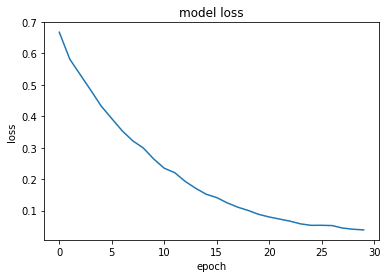

In [24]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

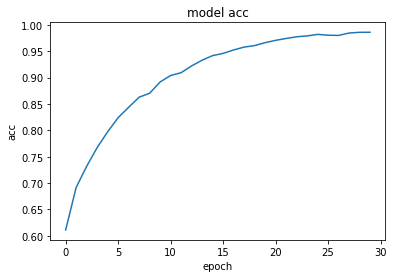

In [26]:
plt.plot(hist.history['acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')